# import the data

In [136]:
# Importing all the necessary packages
import pandas as pd
from pandas.errors import PerformanceWarning
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# ARIMA and Prophet both use .T which causes this annoying warning, so I'm hiding it 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=PerformanceWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency 30min will be used.")

In [137]:
# Import the merged_df
merged_df = pd.read_csv("merged_df.csv")
merged_df.set_index('Datetime', inplace=True)

# Seasonality Predictions

In [138]:
merged_df_2024 = merged_df[(merged_df.index >= '2023-10-01') & (merged_df.index < '9999-01-01')]  # we only look at 2024
merged_df_filtered = merged_df[(merged_df.index >= '2018-01-01') & (merged_df.index < '9999-01-01')]  # we look at everything at first

In [139]:
def calculate_fft(df, variable, threshold_pc):
    # Compute fast Fourier transform
    price_fft = np.fft.fft(df[variable].dropna())

    # Get frequencies corresponding to FFT coefficients
    # d is the interval in terms of days if data is half-hourly, thus frequencies are in cycles per day
    freqs = np.fft.fftfreq(len(price_fft), d=1/48)

    # Calculate amplitudes
    # We need to play with this more I think
    amplitudes = np.abs(price_fft)
    threshold = threshold_pc * np.max(amplitudes)  # Setting a 4% threshold of the maximum amplitude for significance

    # Find frequencies with significant amplitudes
    significant_freqs = freqs[np.where(amplitudes > threshold)]
    significant_amplitudes = amplitudes[np.where(amplitudes > threshold)]
    return zip(significant_freqs, significant_amplitudes)

In [140]:
def prophet_predictions(df, variable, freq_amp):
    # Use Prophet to model_F multiple seasonalities
    prophet_balancing_df = df.reset_index().rename(columns={'Datetime': 'ds', variable: 'y'})
    model_F = Prophet()

    # Adding seasonalities based on significant frequencies
    for freq, amp in freq_amp:
        if freq != 0:  # Ignore the DC component
            period_in_days = 1 / freq
            # Add seasonality to Prophet
            seasonality_name = f"seasonal_freq_{freq:.4f}"
            if period_in_days <= 1:
                fourier_order = 5
            elif period_in_days > 1 and period_in_days > 7:
                fourier_order = 10
            else:
                fourier_order = 20
            model_F.add_seasonality(name=seasonality_name, period=period_in_days, fourier_order=fourier_order)

    # Fit the model_F
    model_F.fit(prophet_balancing_df)

    # Make future dataframe for predictions, 48 * 30 because we need to predict a month
    future = model_F.make_future_dataframe(periods=48, freq='30T')

    forecast = model_F.predict(future)

    # Plot the forecast
    model_F.plot(forecast)
    plt.show()
    return forecast

In [141]:
def t_arima(df, p, q):
    # Fit ARIMA

    # setting the frequency for the arima
    # df = df.asfreq('30T')
    
    if adfuller(df.dropna())[1] < 0.05:
        d = 0
        print("d = 0")
    elif adfuller(df.diff().dropna())[1] < 0.05:
        d = 1
        print("d = 1")
    else:
        d = 2
        print("d = 2")
    arima_model = ARIMA(df.dropna(), order=(p, d, q))
    arima_fit = arima_model.fit()

    forecast = arima_fit.predict(start=0, end=len(df) - 1 + 48)  # we predict for the 48 rows after
    return pd.Series(forecast, index=df.index)

In [ ]:
# XGBoost template
def xgboo(df, variable):
    df = df.select_dtypes(include=[np.number]).dropna(subset=[variable])
    X = df.drop(columns=[variable], axis=1)
    y = df[variable]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    # Filter important features (above a certain threshold, e.g., 0.01)
    important_features = feature_importances[feature_importances > 0.00]
    print("Important features:")
    print(important_features)
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print error metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    return model

def xgboost_optimization(df, variable):
    df = df.select_dtypes(include=[np.number]).dropna(subset=[variable])
    X = df.drop(columns=[variable], axis=1)
    y = df[variable]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.3, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5, 0.7, 1.0],
        'reg_alpha': [0, 0.1, 1, 10],
        'reg_lambda': [1, 2, 5, 10]
    }

    # Set up the model and RandomizedSearchCV
    xgb_model = XGBRegressor(random_state=42)
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=50,
                                    scoring='neg_root_mean_squared_error', cv=3, verbose=1, random_state=42)

    # Fit random search to the data
    random_search.fit(X_train, y_train)

    # Get best parameters and score
    print("Best Parameters:", random_search.best_params_)
    print("Best RMSE Score:", -random_search.best_score_)
    
    # Make predictions on the test set
    y_pred = random_search.predict(X_test)

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Print error metrics
    print("On the test set:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    return random_search

In [143]:
def calculate_rmse(actual, predicted):
    # Ensure actual and predicted have the same length
    if len(actual) != len(predicted):
        raise ValueError("Lists must have the same length.")
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2))
    return rmse

# Seasonality Predictions for System Price

### First we do a simple ARIMA model

In [144]:
arima_preds = t_arima(merged_df_2024["System_Price"], 1, 1)

# Score the model

calculate_rmse(merged_df_2024["System_Price"], arima_preds.dropna())

d = 0


28.68261670890338

### Next we try a more advanced model, prophet

21:23:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:10 - cmdstanpy - INFO - Chain [1] done processing


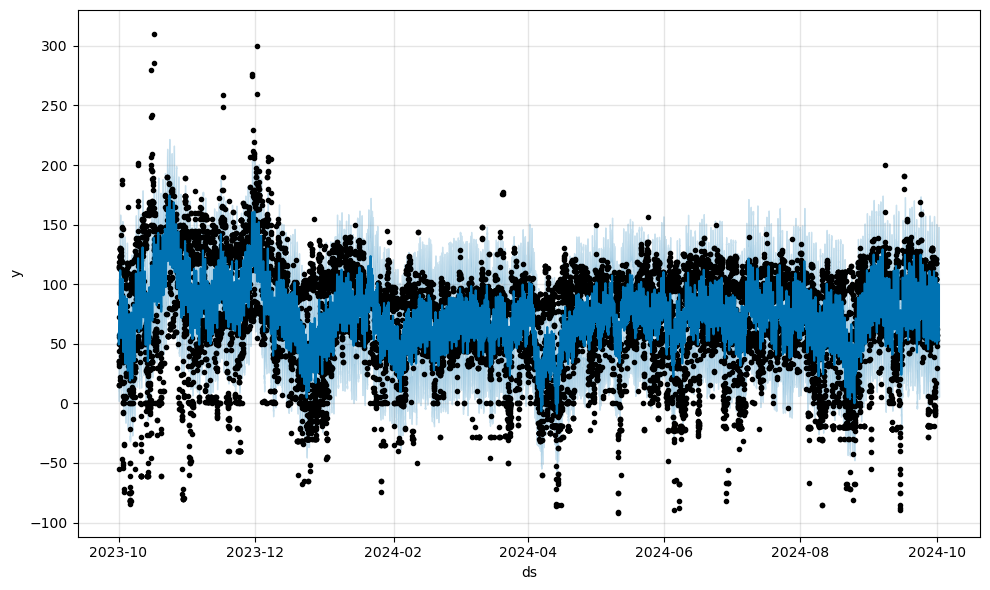

In [146]:
preds_SP = prophet_predictions(merged_df_2024, "System_Price", calculate_fft(merged_df_2024, 'System_Price', 0.03))
# Merging the predictions of prophet to merged df
preds_SP = preds_SP.set_index('ds')
# Convert both indexes to datetime format
preds_SP.index = pd.to_datetime(preds_SP.index)
merged_df_2024.index = pd.to_datetime(merged_df_2024.index)

merged_df_SP = merged_df_2024.join(preds_SP, how='outer')
merged_df_SP.reset_index(inplace=True)

#### Use an ARIMA to predict the trend in residuals that the prophet misses.

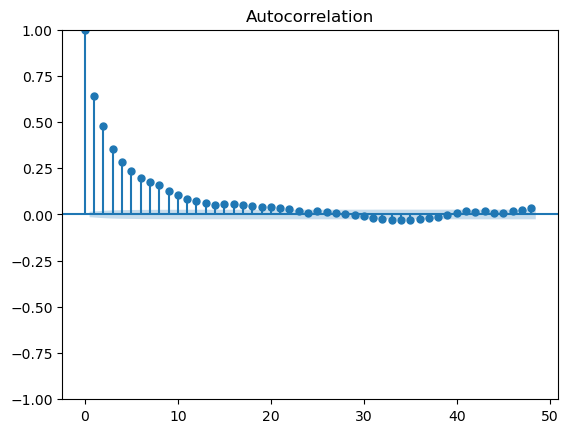

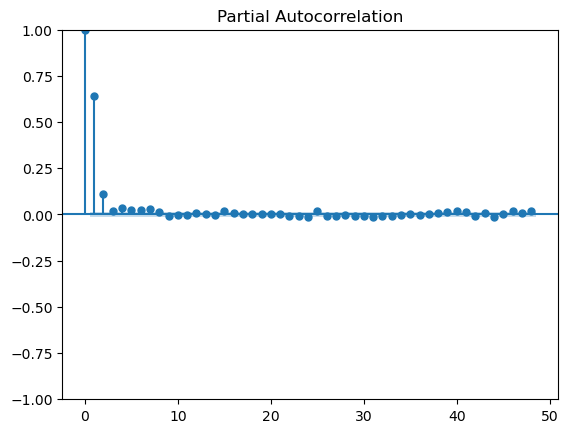

In [147]:
# Step 2: Calculate Residuals
# Calculate residuals as the difference between actual values and Prophet's forecast

merged_df_SP['residuals'] = merged_df_SP["System_Price"] - merged_df_SP['yhat']

# Plot ACF
plot_acf(merged_df_SP['residuals'].dropna(), lags=48)  # 48 lags cover two days if data is half-hourly
plt.show()

# Plot PACF
plot_pacf(merged_df_SP['residuals'].dropna(), lags=48)
plt.show()

d = 0


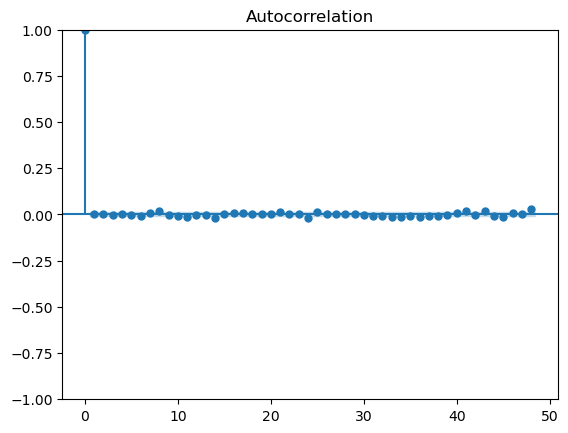

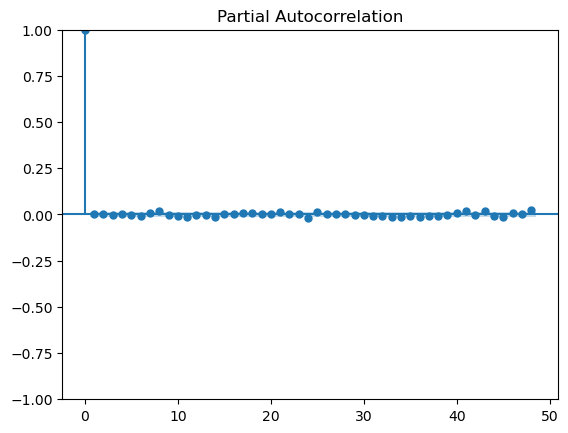

In [148]:
# Step 3: Fit ARIMA on the Residuals
# Using the residuals, fit an ARIMA model
residuals_forecast_series = t_arima(merged_df_SP['residuals'], 2, 3)

# Step 4: Combine the Predictions
# Add the ARIMA residuals forecast back to the Prophet forecast
merged_df_SP['combined_forecast'] = merged_df_SP['yhat'] + residuals_forecast_series

merged_df_SP['final_residuals'] = merged_df_SP['System_Price'] - merged_df_SP['combined_forecast']
# Plot ACF
plot_acf(merged_df_SP['final_residuals'].dropna(), lags=48)
plt.show()
# Plot PACF
plot_pacf(merged_df_SP['final_residuals'].dropna(), lags=48)
plt.show()

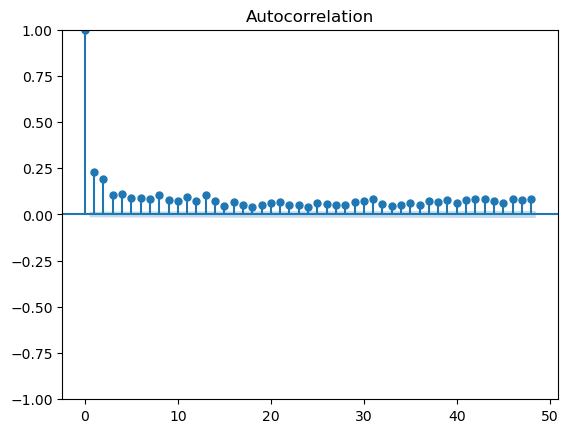

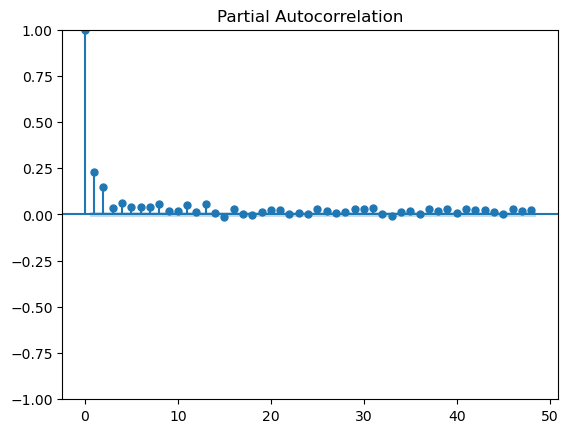

In [149]:
# Plot ACF
plot_acf(merged_df_SP['final_residuals'].dropna() **2, lags=48)
plt.show()
# Plot PACF
plot_pacf(merged_df_SP['final_residuals'].dropna() **2, lags=48)
plt.show()

# XGBoost for all vars SP

In [178]:
# xgboo(merged_df_SP, "System_Price")
xgboost_optimization(merged_df_SP.drop(columns=["final_residuals", "residuals", "yhat"], axis=1), "System_Price")
print("--------------------------VS---------------------------")
merged_df_2024.reset_index(inplace=True)
print(xgboo(merged_df_2024, "System_Price"))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best RMSE Score: 13.180599975048159
On the test set:
Mean Absolute Error (MAE): 8.27378778766226
Mean Squared Error (MSE): 165.07221011613217
Root Mean Squared Error (RMSE): 12.848043046165909
R-squared (R2): 0.9153240519497309
--------------------------VS---------------------------
Important features:
NIV_Outturn                        0.412314
Intraday_Price                     0.356190
Fossil_Hard_Coal                   0.022048
Fossil_Gas                         0.019642
Day_Ahead_Price                    0.015771
Nuclear                            0.014751
Loss_of_Load_Prob                  0.014336
BSAD_Turn_Down                     0.012954
BSAD_Total                         0.012936
Hydro_Run-of-River_and_Poundage    0.012132


In [195]:
temp = merged_df_SP.drop(columns=[col for col in merged_df_SP.columns if col.startswith("seasonal_freq_")])
temp = temp.drop(columns=["NIV_Outturn", "residuals", "yhat", "final_residuals"])
"""
temp = temp.drop(columns=['Biomass', 'Fossil_Gas', 'Fossil_Hard_Coal', 'Fossil_Oil',
       'Hydro_Pumped_Storage', 'Hydro_Run-of-River_and_Poundage', 'Nuclear', "NIV_Outturn", 
       'Solar', 'Wind_Onshore', 'Wind_Offshore', 'BM_Bid_Acceptances', "weekly_upper", "yhat_lower", "daily_lower", "additive_terms_upper", "daily_upper", 
       'BM_Offer_Acceptances', 'BSAD_Turn_Up', 'BSAD_Turn_Down', 'BSAD_Total',"final_residuals", "residuals", "yhat", "additive_terms", "yhat_upper", "daily", "weekly", "additive_terms_lower", "weekly_lower"], axis=1)
"""
xgboo(temp, "System_Price")

Important features:
combined_forecast                  0.416098
Intraday_Price                     0.224003
BM_Offer_Acceptances               0.051177
BM_Bid_Acceptances                 0.044464
Loss_of_Load_Prob                  0.034946
trend                              0.026411
yhat_upper                         0.011891
BSAD_Total                         0.011492
Nuclear                            0.011456
BSAD_Turn_Down                     0.011055
Fossil_Gas                         0.010941
Day_Ahead_Price                    0.010351
Total_Load                         0.009575
Demand_Outturn                     0.009503
Solar                              0.009338
additive_terms                     0.009143
weekly                             0.009086
Biomass                            0.008735
Wind_Onshore                       0.008722
Hydro_Run-of-River_and_Poundage    0.008700
Hydro_Pumped_Storage               0.008577
BSAD_Turn_Up                       0.008341
yhat_lower  

In [ ]:
from sklearn.feature_selection import RFE
# Assuming your DataFrame is named `merged_df` and your target variable is `System_Price`
df = merged_df_SP.drop(columns=["final_residuals", "residuals", "yhat"], axis=1).select_dtypes(include=[np.number]).dropna(subset=["System_Price"])
X = df.drop(columns=["System_Price"], axis=1)
y = df["System_Price"]
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)


rfe = RFE(estimator=xgb_model, n_features_to_select=6, step=1)

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Predict on test set using the selected features
y_pred = rfe.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False])

In [175]:
X.columns[rfe.support_]

Index(['NIV_Outturn', 'Intraday_Price', 'trend', 'seasonal_freq_-0.0082',
       'residuals', 'combined_forecast'],
      dtype='object')

## Iterative XGBoost 

In [150]:
def create_lagged_features(data, target_column, lags):
    """Create lagged features for the target and other variables up to a specified lag."""
    lagged_df = data[[target_column]].copy()
    
    # Create lagged features for each column except the target
    for col in merged_df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f'{col}_lag_{lag}'] = data[col].shift(lag)
        
    # Drop rows with NaN values from lagging
    lagged_df.dropna(inplace=True)
    return lagged_df

# Assume data is up to time t, and we create 5 lagged features
lags = 6
lagged_data = create_lagged_features(merged_df_SP, target_column="System_Price", lags=lags)


In [151]:

# Calculate residuals between actual target and ARIMA predictions up to time t
merged_df_SP['residuals'] = merged_df_SP['System_Price'] - merged_df_SP['combined_forecast']

# Merge lagged features with residuals for training, aligning by index (dates)
train_data = lagged_data.merge(merged_df_SP[['residuals']], left_index=True, right_index=True)

# Split into features and target
X = train_data.drop(columns=['residuals'])
y = train_data['residuals']

# Train-test split (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Optional: Evaluate the model
y_pred = xgb_model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


RMSE: 5.389017492994978


In [162]:
# Initialize predictions for time steps t+1 to t+48
xgb_forecast = []
input_data = X.iloc[-1].values.reshape(1, -1)  # Start with the last row of lagged features

for _ in range(48):
    next_residual = xgb_model.predict(input_data)[0]  # Predict the next residual
    xgb_forecast.append(next_residual)  # Store forecasted residual

    # Update input data by shifting and appending new residual to lagged features
    input_data = np.roll(input_data, -1)
    input_data[0, -1] = next_residual  # Add latest prediction to the end of the input data

# Convert predictions into a Series for easier merging with ARIMA forecasts
merged_df_SP.index = pd.to_datetime(merged_df_SP["index"])

forecast_index = merged_df_SP.index[-48:]
residuals_forecast_series = pd.Series(xgb_forecast, index=forecast_index)


In [167]:
# Assume 'arima_predictions' is extended to t+48
final_forecast = merged_df_SP['combined_forecast'].reindex(forecast_index) + residuals_forecast_series
merged_df_SP.loc[forecast_index, 'combined_combined_forecast'] = final_forecast

# Display the final combined forecast
print(merged_df_SP[['combined_forecast', 'combined_combined_forecast']].tail(48))
print("RMSE:", mean_squared_error(answers["System_Price"], merged_df_SP['combined_combined_forecast'].tail(48), squared=False))


                     combined_forecast  combined_combined_forecast
index                                                             
2024-10-01 00:00:00          50.952281                   27.385005
2024-10-01 00:30:00          51.031921                   35.983824
2024-10-01 01:00:00          49.715558                   30.179206
2024-10-01 01:30:00          47.574449                   21.093971
2024-10-01 02:00:00          46.092236                   12.316601
2024-10-01 02:30:00          45.941629                  -52.209265
2024-10-01 03:00:00          46.585853                  -21.260460
2024-10-01 03:30:00          47.417539                   43.016662
2024-10-01 04:00:00          48.847749                   41.498155
2024-10-01 04:30:00          51.926790                   69.259885
2024-10-01 05:00:00          57.064049                  143.057663
2024-10-01 05:30:00          63.441609                  174.125698
2024-10-01 06:00:00          69.612064                   44.15